In [21]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import glob
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from google.colab import drive
from os import path
drive.mount('/content/drive')

data_root = './drive/MyDrive/NAS/CSED538/DL20'
print(path.exists(data_root))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True


In [2]:
class SimpleCNN(nn.Module):
  def __init__(self, num_classes=20):
    super(SimpleCNN, self).__init__()

    self.relu = nn.ReLU(inplace=True)
    
    # Convolution Feature Extraction Part
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc    = nn.Linear(128*16*16, 20)
  def forward(self, x):
    # Convolution Feature Extraction Part
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)

    # Fully Connected Classifier Part
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

In [10]:
# Network
model = SimpleCNN(num_classes=20)

# Random input
x = torch.randn((1, 3, 64, 64))
out = model(x)
print("Output tensor shape is :", out.shape)

Output tensor shape is : torch.Size([1, 20])


In [4]:
class LoadDataset(Dataset):
    def __init__(self, data_path, transform, mode='train'):
        super(LoadDataset, self).__init__()
        self.data_path = data_path
        self.mode = mode
        self.transform = transform
        
        if mode == "test":
            self.test_load()
        else : 
            self.load_dataset()

    def test_load(self):
        root = os.path.join(self.data_path, self.mode)
        print("root : ", root)
        self.data = glob.glob(root+"/*.png")
        
    def load_dataset(self):
        root = os.path.join(self.data_path, self.mode)
        print("root : ", root)
        self.data = ImageFolder(root=root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == "test":
            img = Image.open(self.data[index]).convert('RGB')
            img = self.transform(img)
            return img
        else:
            img, label = self.data[index]
            img, label = self.transform(img), int(label)
            return img, label

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 32
train_dataset = LoadDataset(data_root, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

root :  ./drive/MyDrive/NAS/CSED538/DL20/train


In [17]:
learning_rate = 5 * 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

model.train()
train_loss, train_accu = [], []
valid_loss, valid_accu = [], []
epoch = 100
for e in range(epoch):
  train_iter = 0
  for image, label in train_loader:
    image, label = Variable(image), Variable(label)

    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()   

    prediction = torch.argmax(output, dim=-1)
    accuracy = prediction.eq(label.data).sum()/batch_size*100
    train_accu.append(accuracy)
    if (e % 20 == 0) and (train_iter % 300 == 0):
        print(f'** Epoch: {e} **')
        print(f'Train Step: {train_iter}\tLoss: {loss:.3f}\tAccuracy: {accuracy:.3f}')
    train_iter += 1

** Epoch: 0 **
Train Step: 0	Loss: 11.661	Accuracy: 56.250
** Epoch: 20 **
Train Step: 0	Loss: 0.032	Accuracy: 65.625
** Epoch: 40 **
Train Step: 0	Loss: 0.000	Accuracy: 65.625
** Epoch: 60 **
Train Step: 0	Loss: 0.000	Accuracy: 65.625
** Epoch: 80 **
Train Step: 0	Loss: 0.000	Accuracy: 65.625


In [36]:
model.eval()
test_dataset = LoadDataset(data_root, transform, "test")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

root :  ./drive/MyDrive/NAS/CSED538/DL20/test


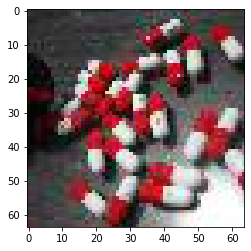

tensor(2)


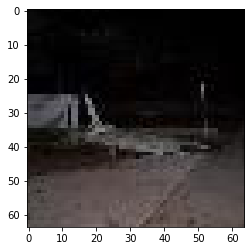

tensor(1)


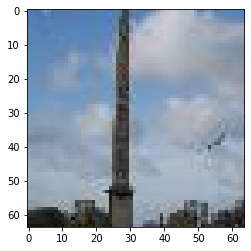

tensor(0)


In [37]:
for image in test_loader:
    image = Variable(image)

    optimizer.zero_grad()
    output = model(image)
    predictions = torch.argmax(output, dim=-1)

    for i, (img, pred) in enumerate(zip(image, predictions)):
      plt.imshow( img.permute(1, 2, 0) )
      plt.show()
      print(pred)

In [40]:
torch.save(model.state_dict(), path.join(data_root, 'simpleCNN.pth'))